# `AbsorptionModel` Tutorial

Trey V. Wenger (c) September 2024

Here we demonstrate the basic features of the `AbsorptionModel` model. `AbsorptionModel` models 21-cm optical depth spectra like those obtained from typical HI absorption observations.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi
print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.6.3+4.ga230ddc.dirty
caribou_hi version: 1.0.0-staging+1.g238726f.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `AbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the observation to be named `"absorption"`.

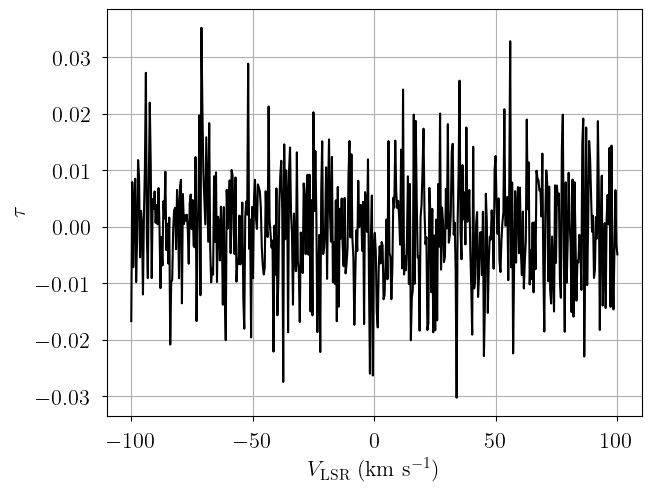

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = np.linspace(-100.0, 100.0, 500) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms = 0.01 # optical depth

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
absorption = rms * np.random.randn(len(velo_axis))

dummy_data = {"absorption": SpecData(
    velo_axis,
    absorption,
    rms,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel=r"$\tau$",
)}

# Plot dummy data
fig, ax = plt.subplots(layout="constrained")
ax.plot(dummy_data["absorption"].spectral, dummy_data["absorption"].brightness, "k-")
ax.set_xlabel(dummy_data["absorption"].xlabel)
_ = ax.set_ylabel(dummy_data["absorption"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
from caribou_hi import AbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = AbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI = [20.0, 0.5], # mean and width of log10(NHI) prior (cm-2)
    prior_log10_nHI = [1.0, 0.5], # mean and width of log10(nHI) prior (cm-3)
    prior_log10_tkin = [2.0, 0.5], # mean and width of log10(kinetic temp) prior (K)
    prior_log10_n_alpha = [-6.0, 0.5], # mean and width of log10(n_alpha) prior (cm-3)
    prior_log10_larson_linewidth = [0.2, 0.05], # mean and width of log10(larson_linewidth) prior (km s-1)
    prior_larson_power = [0.4, 0.05], # mean and width of larson_power prior
    prior_velocity = [0.0, 2.0], # mean and width of velocity prior (km/s)
    prior_rms_absorption = 0.1, # width of emission rms (K) prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

In [22]:
# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([21.5, 21.0, 20.5]),
    "log10_nHI": np.array([2.0, 1.5, 1.0]),
    "log10_tkin": np.array([2.75, 2.15, 2.25]),
    "log10_n_alpha": np.array([-6.0, -5.0, -6.0]),
    "log10_larson_linewidth": np.array([0.15, 0.2, 0.25]),
    "larson_power": np.array([0.5, 0.3, 0.3]),
    "velocity": np.array([0.0, -5.0, 5.0]),
    "rms_absorption": rms,
    "baseline_absorption_norm": np.array([-2.0, 3.0, 5.0])
}
absorption = model.model["absorption"].eval(sim_params)
data = {"absorption": SpecData(
    velo_axis,
    absorption,
    rms,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel=r"$\tau$",
)}

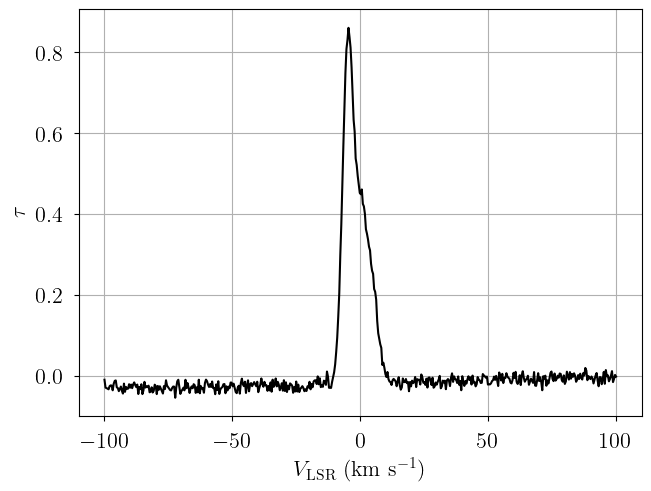

In [23]:
# Plot data
fig, ax = plt.subplots(layout="constrained")
ax.plot(data["absorption"].spectral, data["absorption"].brightness, "k-")
ax.set_xlabel(data["absorption"].xlabel)
_ = ax.set_ylabel(data["absorption"].ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `AbsorptionModel`. Here we create a new model with the simulated data.

In [24]:
# Initialize and define the model
model = AbsorptionModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI = [20.0, 0.5], # mean and width of log10(NHI) prior (cm-2)
    prior_log10_nHI = [1.0, 0.5], # mean and width of log10(nHI) prior (cm-3)
    prior_log10_tkin = [2.0, 0.5], # mean and width of log10(kinetic temp) prior (K)
    prior_log10_n_alpha = [-6.0, 0.5], # mean and width of log10(n_alpha) prior (cm-3)
    prior_log10_larson_linewidth = [0.2, 0.05], # mean and width of log10(larson_linewidth) prior (km s-1)
    prior_larson_power = [0.4, 0.05], # mean and width of larson_power prior
    prior_velocity = [0.0, 2.0], # mean and width of velocity prior (km/s)
    prior_rms_absorption = 0.1, # width of emission rms (K) prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

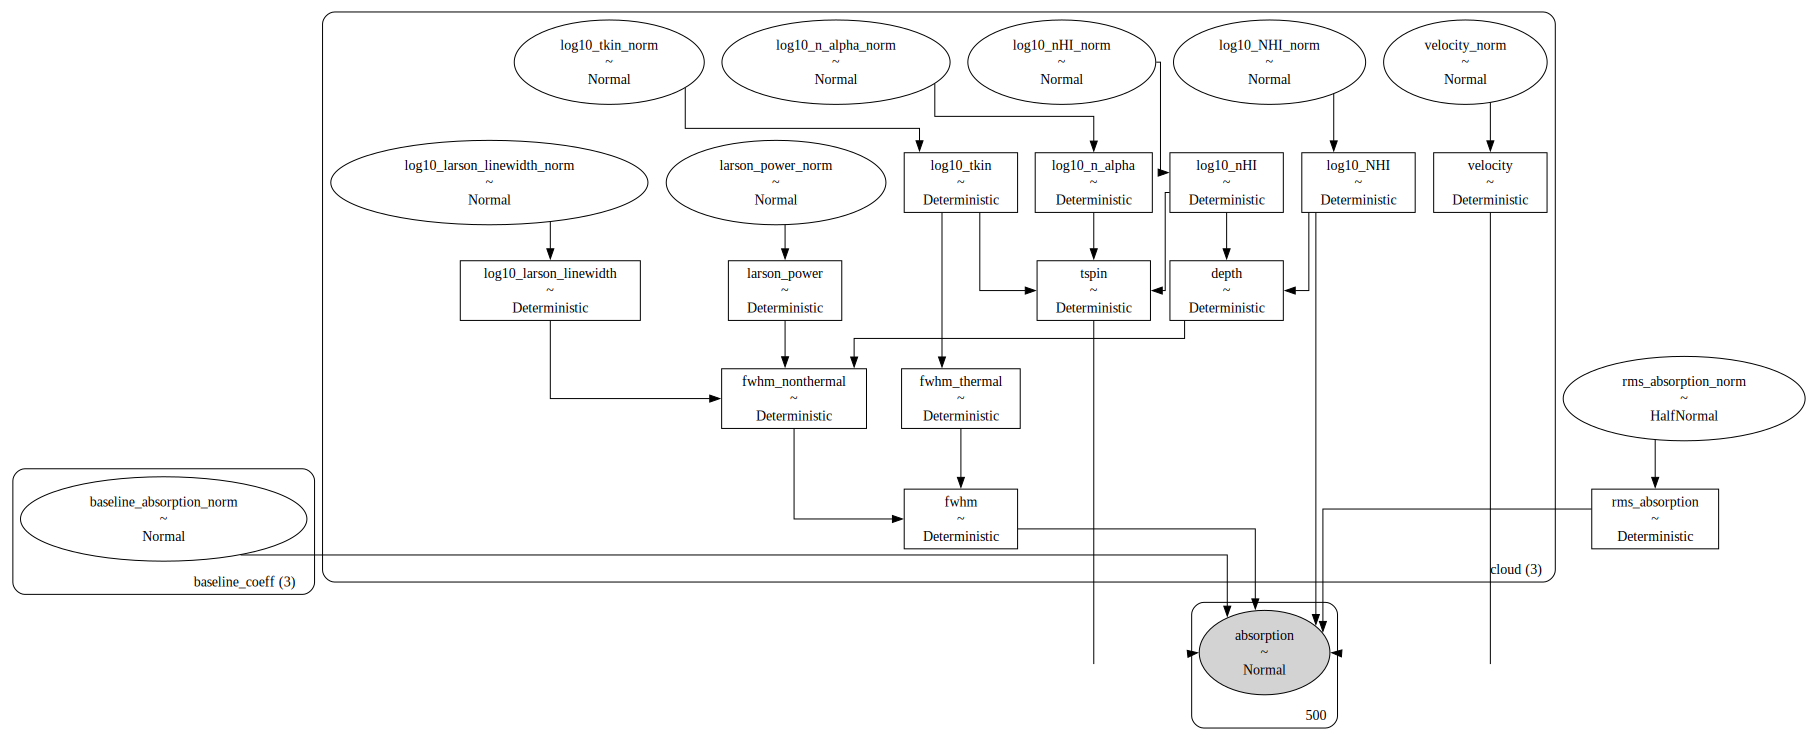

In [25]:
# Plot model graph
model.graph().render('absorption_model', format='png')
model.graph()

In [26]:
# model string representation
print(model.model.str_repr())

   baseline_absorption_norm ~ Normal(0, <constant>)
             log10_NHI_norm ~ Normal(0, 1)
             log10_nHI_norm ~ Normal(0, 1)
            log10_tkin_norm ~ Normal(0, 1)
         log10_n_alpha_norm ~ Normal(0, 1)
log10_larson_linewidth_norm ~ Normal(0, 1)
          larson_power_norm ~ Normal(0, 1)
              velocity_norm ~ Normal(0, 1)
        rms_absorption_norm ~ HalfNormal(0, 1)
                  log10_NHI ~ Deterministic(f(log10_NHI_norm))
                  log10_nHI ~ Deterministic(f(log10_nHI_norm))
                 log10_tkin ~ Deterministic(f(log10_tkin_norm))
              log10_n_alpha ~ Deterministic(f(log10_n_alpha_norm))
     log10_larson_linewidth ~ Deterministic(f(log10_larson_linewidth_norm))
               larson_power ~ Deterministic(f(larson_power_norm))
                   velocity ~ Deterministic(f(velocity_norm))
                      tspin ~ Deterministic(f(log10_tkin_norm, log10_n_alpha_norm, log10_nHI_norm))
               fwhm_thermal ~ Determini

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [absorption, baseline_absorption_norm, larson_power_norm, log10_NHI_norm, log10_larson_linewidth_norm, log10_nHI_norm, log10_n_alpha_norm, log10_tkin_norm, rms_absorption_norm, velocity_norm]


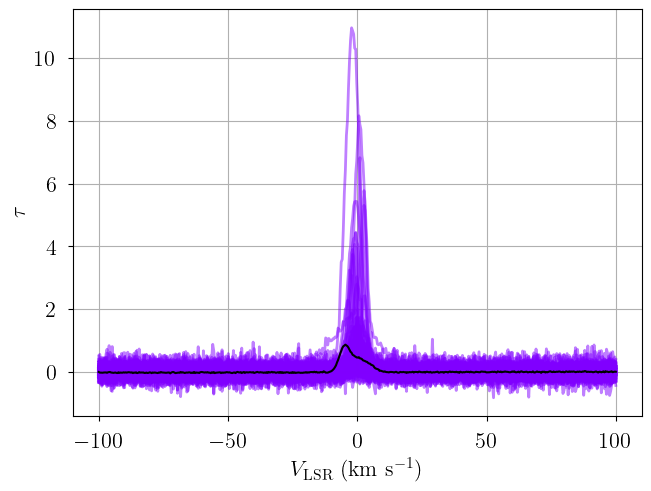

In [27]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [28]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5000
Interrupted at 4,999 [4%]: Average Loss = -866.59


Runtime: 0.25 minutes


In [29]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_absorption_norm[0],-0.293,0.004,-0.299,-0.284,0.000,0.000,910.0,1023.0,NaN
baseline_absorption_norm[1],0.205,0.013,0.184,0.231,0.000,0.000,958.0,928.0,NaN
baseline_absorption_norm[2],0.364,0.081,0.208,0.506,0.003,0.002,774.0,785.0,NaN
depth[0],24.078,1.357,21.558,26.545,0.045,0.032,911.0,905.0,NaN
depth[1],24.928,1.002,23.062,26.811,0.031,0.022,1082.0,1013.0,NaN
depth[2],7.834,0.212,7.445,8.242,0.007,0.005,988.0,937.0,NaN
fwhm[0],9.928,0.358,9.294,10.622,0.011,0.008,977.0,1024.0,NaN
fwhm[1],9.916,0.271,9.439,10.419,0.008,0.006,1050.0,982.0,NaN
fwhm[2],4.689,0.076,4.541,4.824,0.002,0.002,988.0,942.0,NaN
fwhm_nonthermal[0],9.780,0.363,9.136,10.482,0.012,0.008,977.0,1024.0,NaN


Sampling: [absorption]


Output()

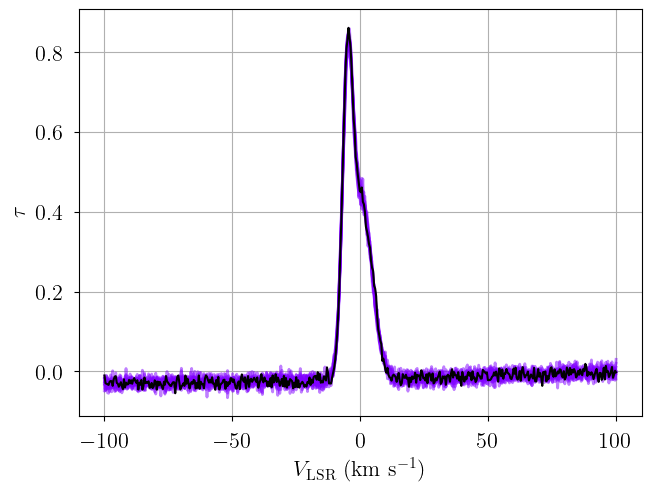

In [30]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [31]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5000
Interrupted at 4,999 [4%]: Average Loss = -866.59
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_norm, log10_NHI_norm, log10_nHI_norm, log10_tkin_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm, velocity_norm, rms_absorption_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 861 seconds.


Runtime: 14.88 minutes


In [32]:
model.solve(p_threshold=0.9)

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [2 0 1]
Chain 1 order: [0 2 1]
Chain 2 order: [2 0 1]
Chain 3 order: [0 2 1]
Adopting (first) most common order: [0 2 1]


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [33]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_absorption_norm[0],-0.289,0.005,-0.299,-0.279,0.000,0.000,3337.0,3141.0,1.00
baseline_absorption_norm[1],0.209,0.011,0.188,0.229,0.000,0.000,5877.0,3120.0,1.00
baseline_absorption_norm[2],0.279,0.103,0.087,0.471,0.002,0.001,3478.0,2546.0,1.00
depth[0],10.284,14.532,0.262,28.939,0.566,0.401,887.0,716.0,1.01
depth[1],19.486,17.243,0.065,45.960,0.392,0.277,973.0,316.0,1.00
depth[2],12.138,12.560,1.991,27.667,0.266,0.188,3320.0,2650.0,1.00
fwhm[0],4.898,1.317,3.299,8.739,0.078,0.058,680.0,281.0,1.00
fwhm[1],6.642,1.028,4.623,8.500,0.050,0.036,741.0,321.0,1.00
fwhm[2],4.981,0.131,4.690,5.188,0.006,0.005,677.0,320.0,1.00
fwhm_nonthermal[0],4.392,1.507,2.249,8.919,0.084,0.065,661.0,281.0,1.00


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [absorption]


Output()

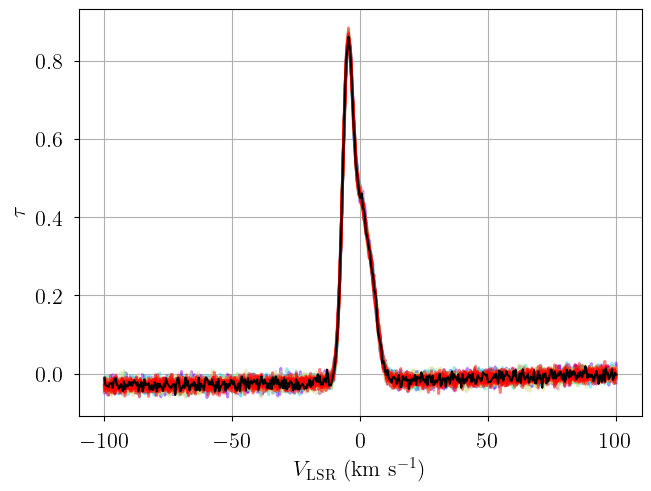

In [34]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

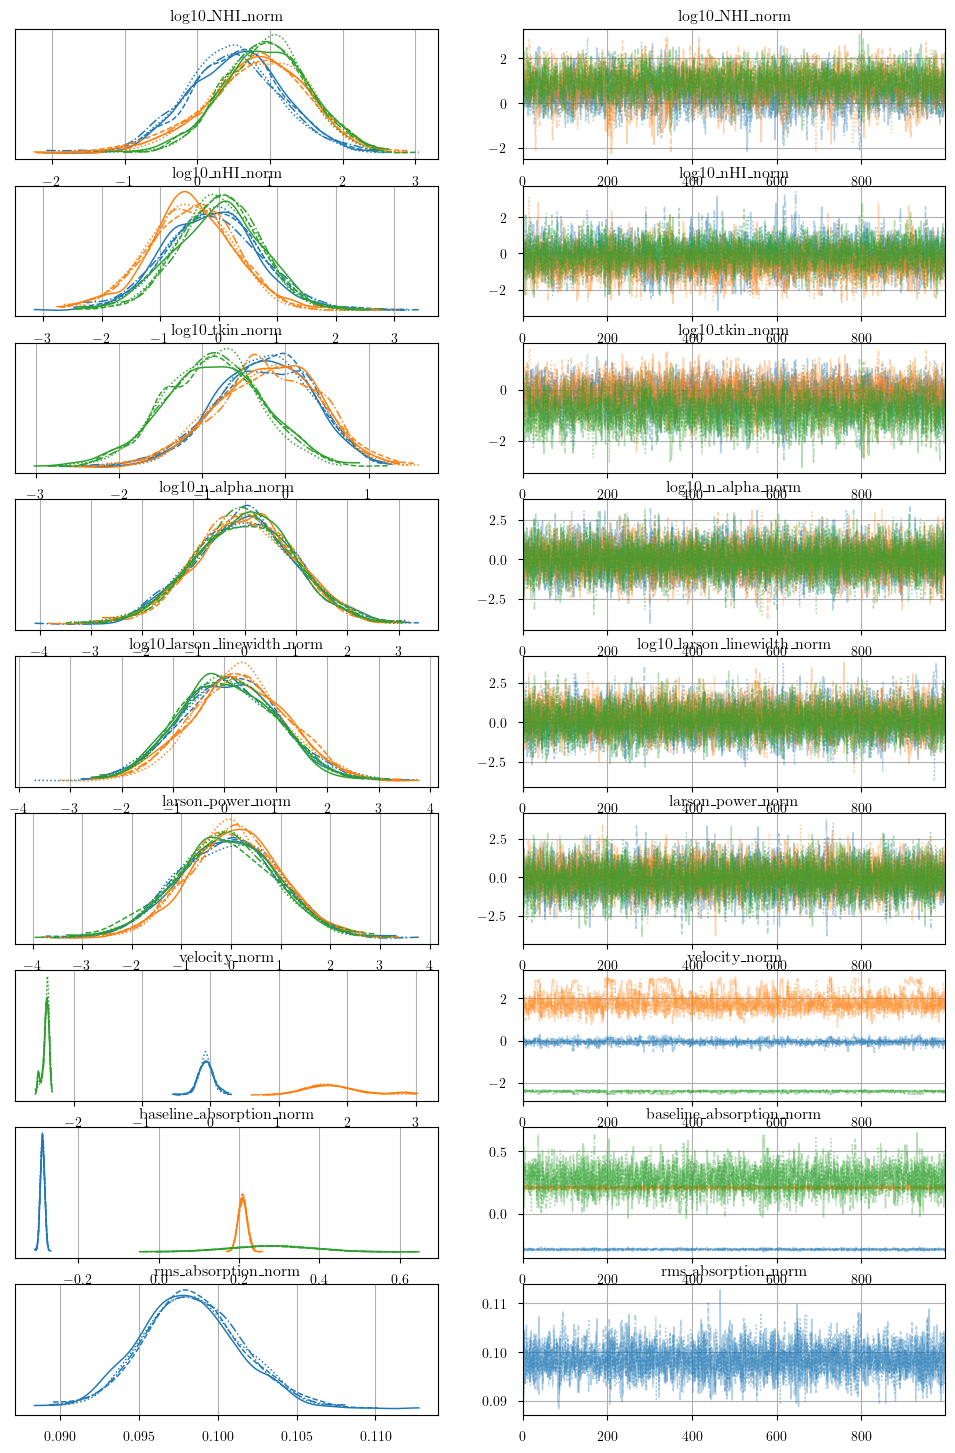

In [35]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

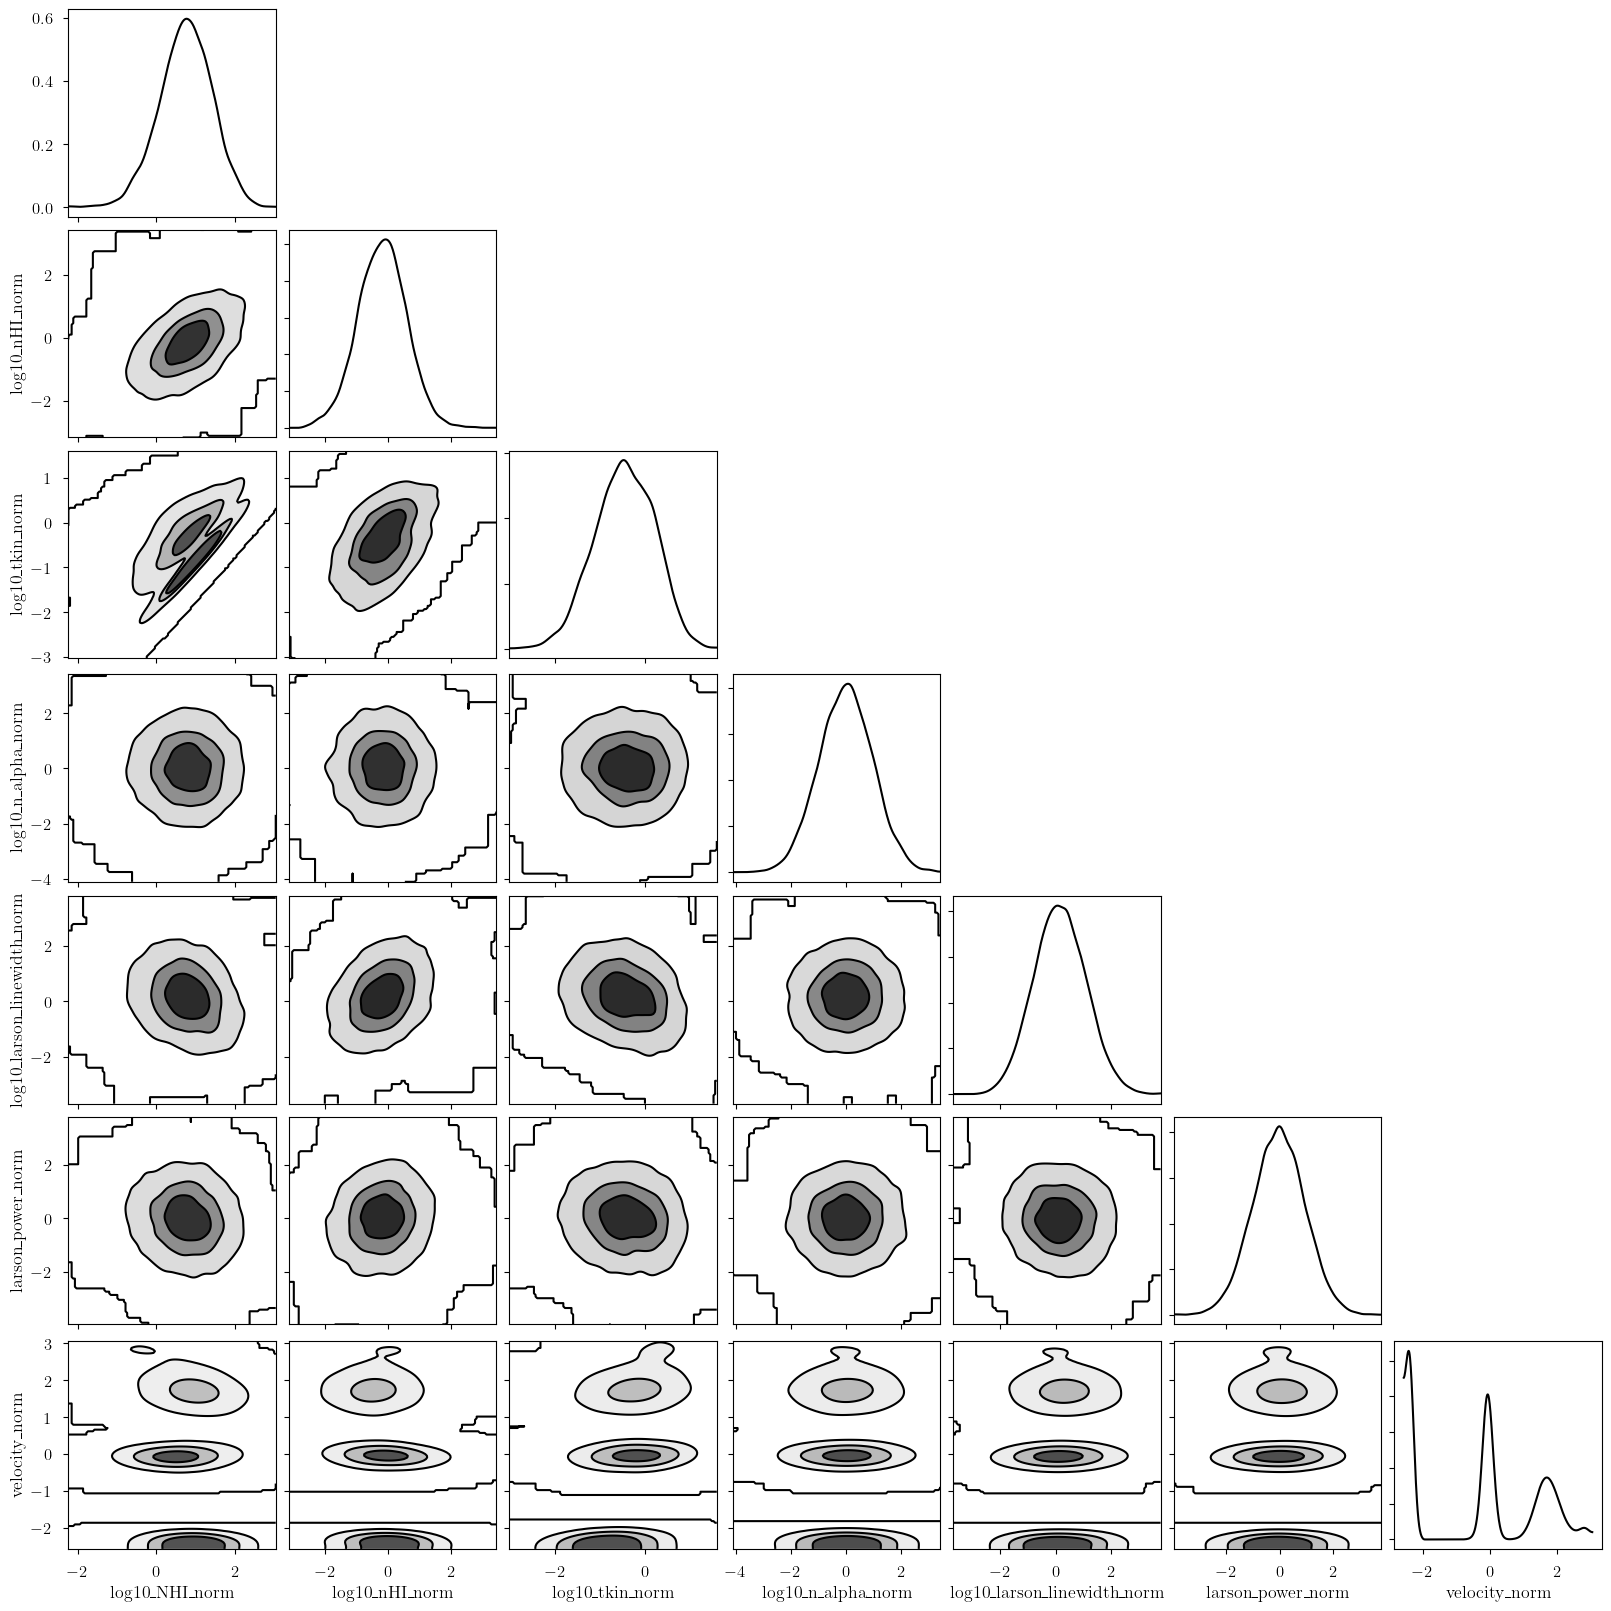

In [36]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud.

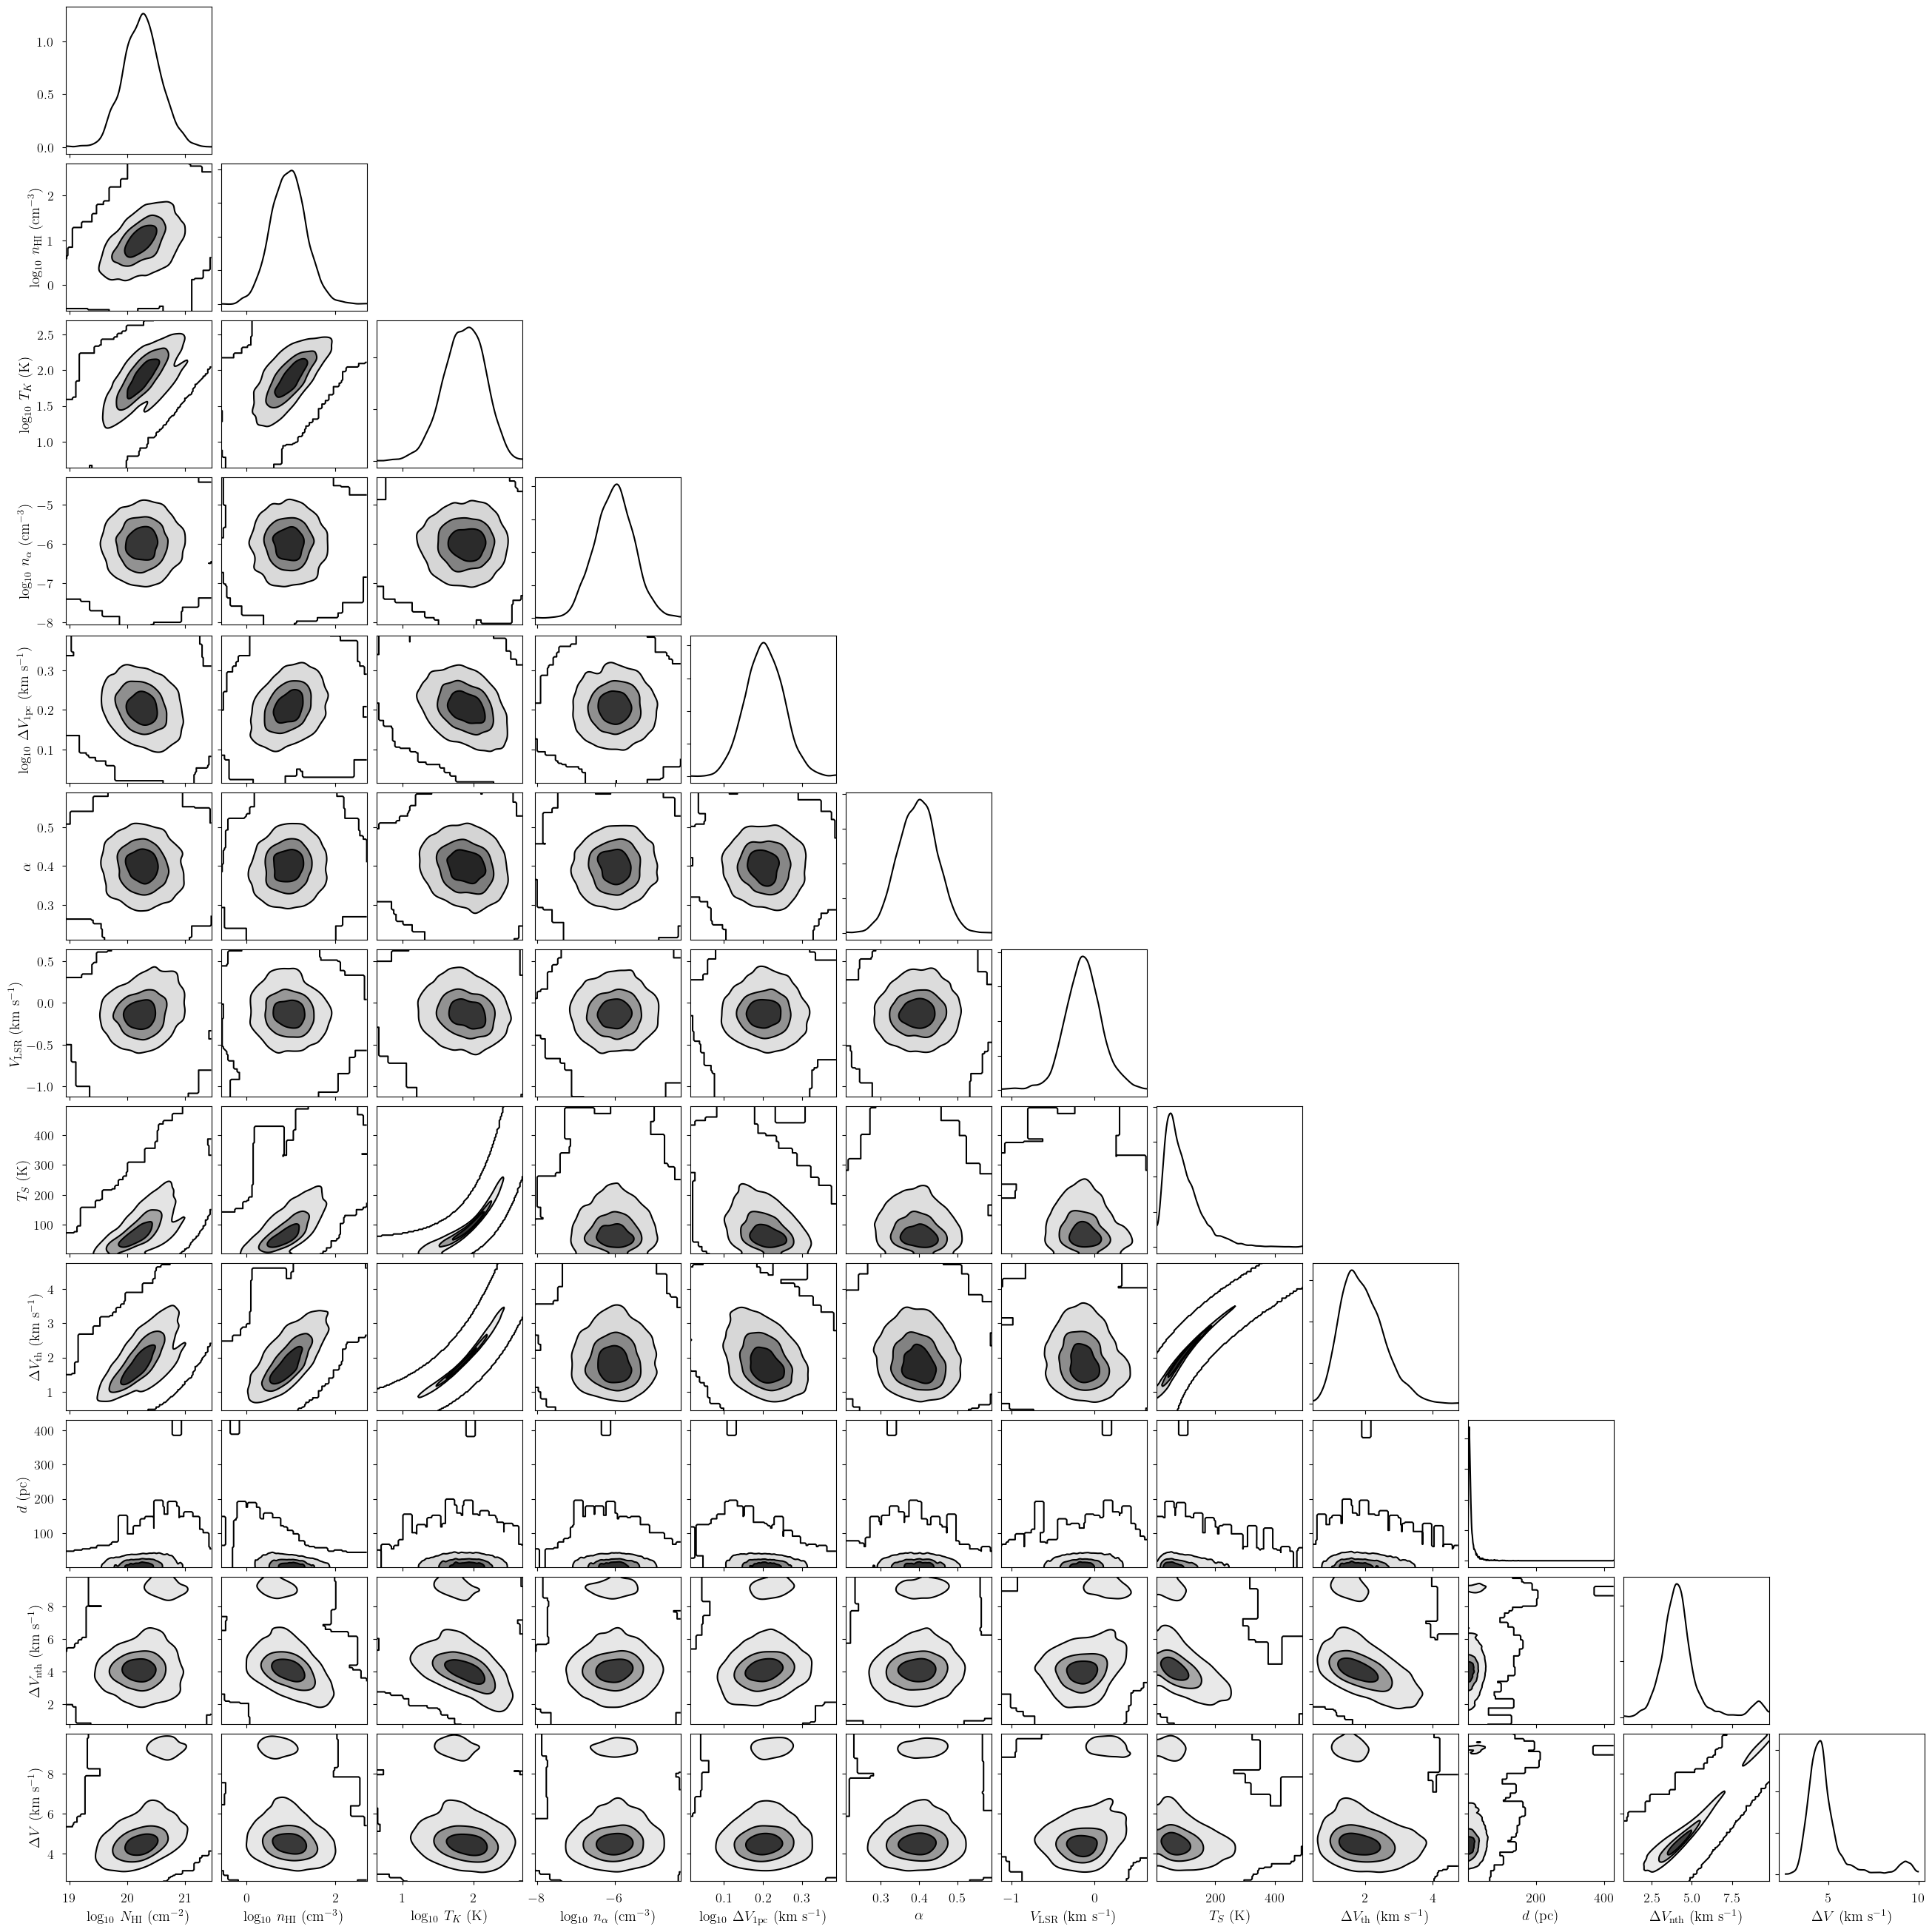

In [37]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [38]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -2644.109569085919


,mean,sd,hdi_16%,hdi_84%
baseline_absorption_norm[0],-0.289,0.005,-0.294,-0.283
baseline_absorption_norm[1],0.209,0.011,0.197,0.219
baseline_absorption_norm[2],0.279,0.103,0.174,0.379
depth[0],10.284,14.532,1.314,9.573
depth[1],19.486,17.243,4.066,23.180
depth[2],12.138,12.560,3.560,12.880
fwhm[0],4.898,1.317,3.807,5.097
fwhm[1],6.642,1.028,6.099,7.612
fwhm[2],4.981,0.131,4.916,5.120
fwhm_nonthermal[0],4.392,1.507,3.120,4.903
